In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
import datetime
import os
import sklearn
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 1
%aimport ShortTermFeatures

%matplotlib inline
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


https://github.com/tyiannak/pyAudioAnalysis

## initial attempt

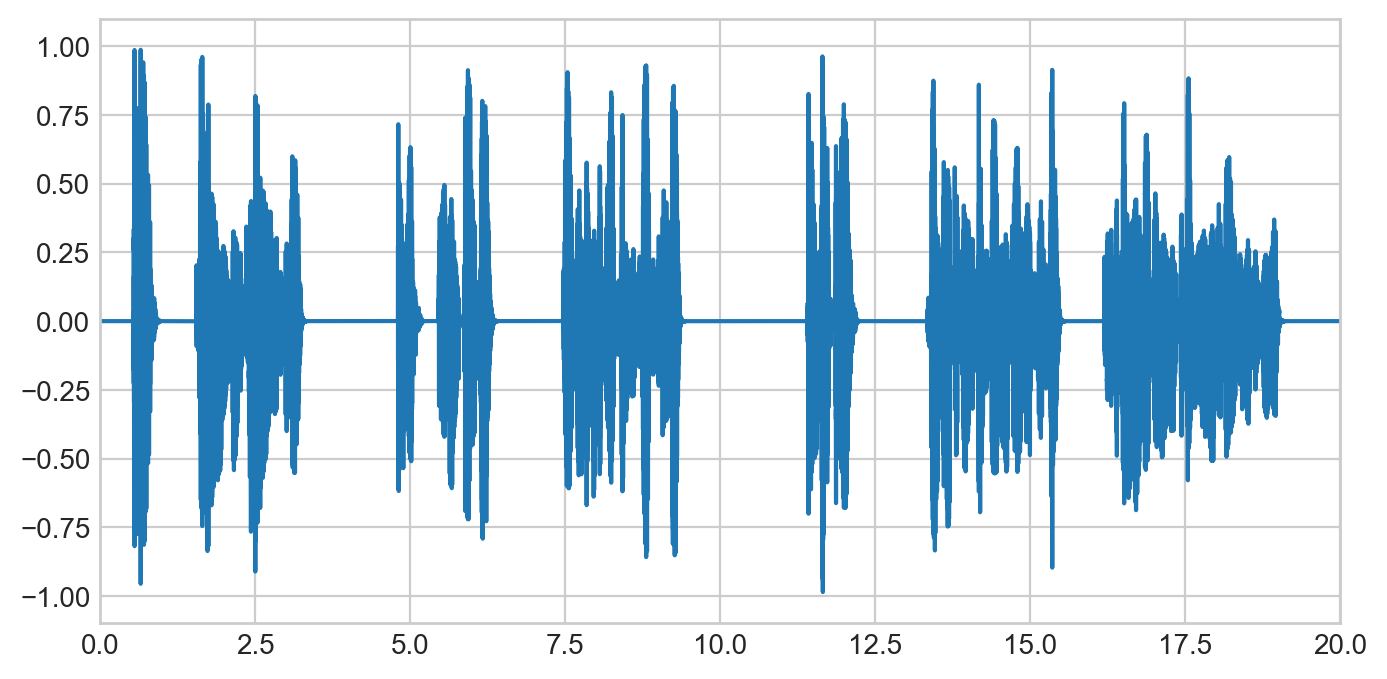

In [14]:
# load audio
filename = './data/Track 2.wav'
data, fs = sf.read(filename, dtype='float32')
time = np.linspace(0, len(data) / fs, num=len(data))

# creat channel name
prefix = 'channel_'
n_channels = data.shape[1]
n_str = np.arange(1, n_channels + 1, 1, dtype=str)
channels = [prefix + i for i in n_str]

# convert to pandas df
pd_data = pd.DataFrame(data, columns=channels)
pd_data['seconds'] = time

# visulise signal 
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(pd_data['seconds'], pd_data['channel_1'])

ax.set_xlim([0, 20])
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")
plt.show()

## inaSpeechSegmenter

https://github.com/ina-foss/inaSpeechSegmenter

In [5]:
# Load the API (Current warning is related to h5py and has no consequences)
from inaSpeechSegmenter import Segmenter, seg2csv
seg = Segmenter()

In [30]:
segments = seg(filename)
pd_segments = pd.DataFrame(segments).rename(columns={0:'Class', 1:'Start', 2:'Stop'})

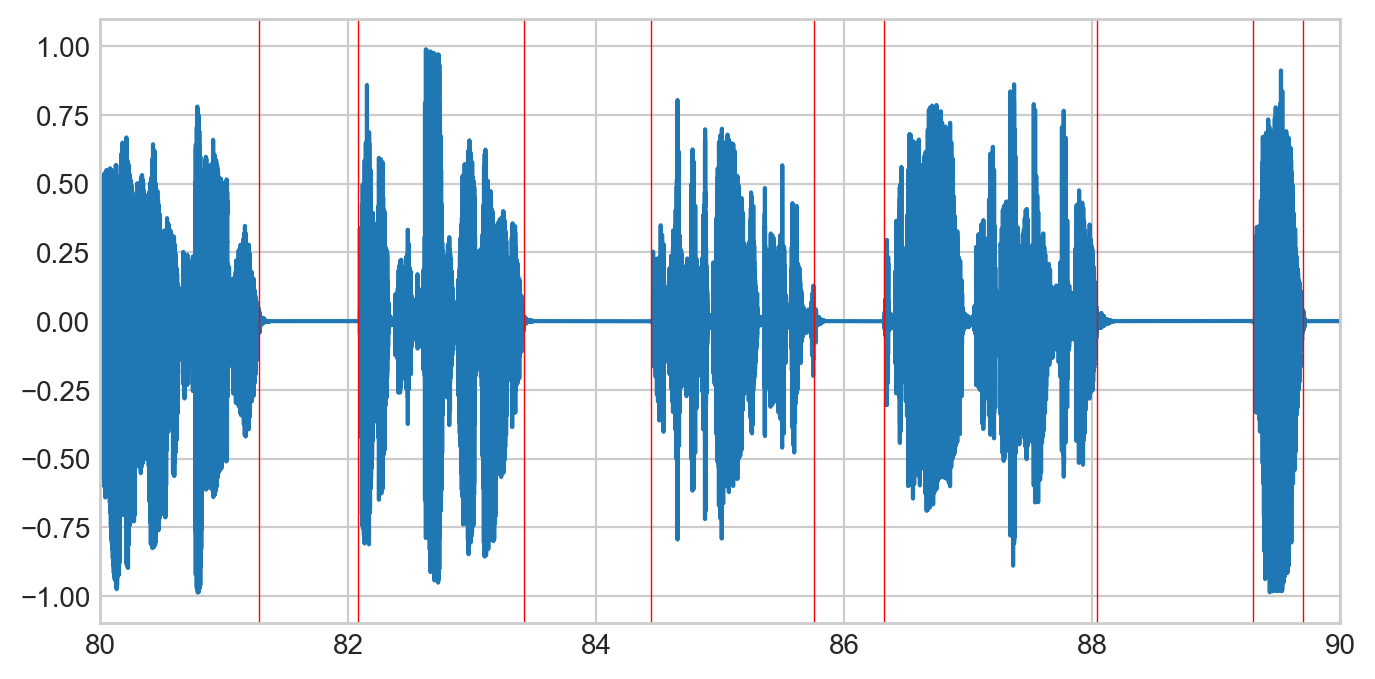

In [43]:
# visulise signal 
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(pd_data['seconds'], pd_data['channel_1'])
pd_pause = pd_segments[pd_segments.Class == 'noEnergy']
for i in range(len(pd_pause)):
    ax.axvline(x=pd_pause.iloc[i]['Start'], color='red', lw=0.5)
    ax.axvline(x=pd_pause.iloc[i]['Stop'], color='red', lw=0.5)

ax.set_xlim([80, 90])
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")
plt.show()

In [124]:
# str(datetime.timedelta(seconds=65066))
# apt-get install ffmpeg libavcodec-extra

'18:04:26'